# Earthquakes and Self-Organized Criticality

## Introduction

The earth's crust is made of up plates that are separated by fault lines. Over time, these plates slowly deform, and build up potential energy until they shift all at once. This is an earthquake, and it is very hard to predict exactly when it will happen. The size of an earthquake is measured using the Richter scale. It is a logarithmic scale that representing the amount one plate shifts relative to another. We use a logarithmic scale, because it there are a wide range of magnitudes, and small earthquakes are more common than large ones. The Gutenberg-Richter law states the probability of an earthquake of a certain magnitude happening:

\begin{equation*}    
P (M) = Ae^{-bM}
\end{equation*}

Where M is the magnitude. Power law distributions like this are rare, and they suggest that the earth must be at a certain critical point in density and temperature in order for earthquakes to happen $^{[1]}$. The tendency for the earth to be shifted towards this critical point as a result of the earthquake phenomena is called self-organized criticality (SOC). Scientists disagree on whether the earth's crust is in a state of SOC. If it is, then all earthquakes have an equally likely chance of being catastrophic. There is evidence to suggest that this is not the case. For example, the majority of large earthquakes are preceded by a buildup of intermediate events $^{[2]}$. 

To understand the basic behavior of earthquakes, we can use a model that contains a series of blocks and springs in between two plates on the top and bottom. These represent two of the earth's adjacent plates that slide past each other. The top plate moves at a steady and slow velocity, and it is connected to each block by a leaf spring. As a result, the leaf springs will slowly build up tension until a block moves causing other blocks to move. This is an earthquake. In this model, the friction force between the bottom plate and the blocks decreases as the velocity of the block increases $^{[1]}$.

![image.png](Spring Force Diagram.png)


## Model

The equations that model the spring force on the blocks $^{[1]}$:  
* Spring force on block from neighboring blocks:
    
\begin{equation*}    
F_b = -k_c(x_i - x_{i+1}) - k_c(x_i - x_{i-1}) 
\end{equation*}

* Force of a leaf spring from the top plate on block: 

\begin{equation*}    
F_l = -k_p(x_i - v_0 t)
\end{equation*} 
    
* Friction force due to bottom plate: 

\begin{equation*}
F_f = -\frac{F_0 sin(v_i)}{1 + |v_i / v_f|}
\end{equation*}

Overall differential equation of motion:  
* This equation combines the above equations into one differential equation relating the position of block i to the total force acting on it.

\begin{equation*}
m_i \frac{d^2 x_i}{dt^2} = k_c(x_{i+1} + x_{i-1} - 2x_i) + k_p(v_0 t - x_i) + F_f
\end{equation*}

* If we break this up, we have: 

\begin{equation*}    
\frac{dx_i}{dt} = v_i \space\space and \space\space m_i \frac{d v_i}{dt} = k_c(x_{i+1} + x_{i-1} - 2x_i) + k_p(v_0 t - x_i) + F_f
\end{equation*}

Where for each block:  
$F_b$ is force from neighboring block  
$F_l$ is the force from the leaf spring  
$F_f$ is the friction force from the bottom plate  
$k_c$ is the spring constant of springs between blocks  
$k_l$ is the spring constant of the leaf springs  
$x_i$ is the position of block i  
$v_i$ is the velocity of block i  
$m_i$ is the mass of block i  
$V_0$ is the static friction force  
$V_f$ is the friction coefficient that determines how friction relates to velocity

## Numerical Methods

In [1]:
import pylab as plt
import numpy as np
import random
%matplotlib inline

In [1]:
def friction (vi, vf, F0):
    """
    Returns the friction of the bottom plate against blocks moving at a specific velocity
    
    Arguments:  vi - initial velocity of the block
                vf - final velocity of the block
                F0 - the static friction force
    
    Returned: The force due to friction
    
    Examples:
    
    >>> friction (0, 1, 20)
    -20.0
    
    >>> friction (1, 1, 20)
    -10.0
    """
    # Calculates sign of vi
    if vi == 0:
        sign = 1
        
    else:
        sign = vi / abs(vi)
        
    force = -((F0) * sign / (1 + abs(vi/vf)))
    return force

In [3]:
def blockMotion (t, blockPositions, vBlock, i, blockNum, kp, kc, mass, F0, v0, vf):
    """
    Returns the differential equation that models the motion of the blocks
    
    Arguments:  t - time
                blockPositions - the positions of the blocks
                vBlock - the velocity of the block
                i - the index of the current block
                blockNum - the number of blocks
                kp - spring constant of leaf springs
                kc - spring constant of springs between blocks
                mass - mass of individual block
                F0 - the static friction force
                v0 - initial velocity of top plate
                vf - the friction coefficient
                
    Returned: The differential equation modeling the motion of the individual blocks
    
    Examples:
    
    >>> blockMotion (0, (0, 1, 2, 3, 4), 0, 2, 5, 0, 0, 1, 0, 1, 20)
    array([ 0.,  0.])
    
    """
    # Sets position and velocity of the block
    xi = blockPositions[i]
    vi = vBlock
    
    # Block motion for the first block, connected to a block one distance unit away
    if i == 0:
        xiM = xi - 1
        xiP = blockPositions[i + 1]
        totalForce = (kc*(xiP + xiM - 2 * xi) + kp * (v0 * t - xi + i) + friction (vi, vf, F0)) / mass
    
    # Block motion for the last block, connected to a block one distance unit away
    elif i == blockNum - 1:
        xiM = blockPositions[i - 1]
        xiP = xi + 1
        totalForce = (kc*(xiP + xiM - 2 * xi) + kp * (v0 * t - xi + i) + friction (vi, vf, F0)) / mass
   
    # Block motion for all the middle blocks, connected to their neighbors
    else:
        xiM = blockPositions[i - 1]
        xiP = blockPositions[i + 1]
        totalForce = (kc*(xiP + xiM - 2 * xi) + kp * (v0 * t - xi + i) + friction (vi, vf, F0)) / mass
    
    # If spring force is large enough to overpower friction, change velocity
    if totalForce <= 0:
        dv = -vi
        vi = 0
        dx = vi
        
    else: 
        dx = vi
        dv = totalForce
        
    return np.array([dx, dv], float)

In [4]:
def eulerCoupled (f, n, blockPositions, vBlock, blockNum, interval, steps, *args):
    """ 
    Solve a coupled system of ODEs by Euler method with fixed number of steps.

    Arguments:  f - function giving ODE as y'=f(x,y)
                n - the number of ODEs
                blockPositions - the array containing the initial block positions
                vBlock - initial block velocity
                blockNum - the number of blocks
                interval - tuple region (a,b) on which to solve ODE
                steps - number of steps
    
    Returned: An array containing the positions and velocities of the blocks over time
    """

    (a,b) = interval  # endpoints
    h = (b-a)/steps  # step size
    points = np.zeros((steps + 1, blockNum*2 + 1)) # array to contain all the block positions and velocities over time

    # set up initial point
    t = a    
    points[0,0] = t
    count = 0
    
    # Sets up first row of poitns
    for l in range(1, blockNum + 1):
        points[0,l] = blockPositions[count]   
        count += 1
    for m in range(blockNum + 1, blockNum * 2 + 1):
        points[0,m] = vBlock

    for k in range(1,steps+1): # Repeats for each timestep                   
        t = t + h
        points[k,0] = t
        
        for i in range(0, blockNum): # Repeats for each block
            r = np.array([points[k-1, i + 1], points[k-1, i + 1 + blockNum]]) # Updates r from previous timestep

            r_new = r + h * f(t, blockPositions, r[1], i, blockNum, *args) # Calculates new r
            
            r = r_new            
            blockPositions[i] = r[0]

            # Saves values to points
            points[k,i + 1] = r[0]
            points[k,i + 1 + blockNum] = r[1]


    return points

In [5]:
def countQuakes (earthquakes, blockNum, i):
    """
    Produces a list of each earthquake and its magnitude
    
    Arguments:  earthquakes - the array containing all earthquake data
                blockNum - the number of blocks
                i - the block index to be examined
                
    Returned: a list containing the magnitude of each earthquake
    """    
    quakes = []
    count = 0
    while count < len(earthquakes):
        if earthquakes[count, blockNum + i] > 1:
            quakes.append(earthquakes[count + 500, i] - earthquakes[count - 500, i])
            count += 500
        count += 1
        
    return quakes

In [37]:
def countMagnitudes (magnitudes):
    """
    Produces a list of the number of earthquakes that fall within a certain range of magnitudes
    
    Arguments: magnitudes - a list of magnitudes
                
    Returned: a list containing the number of occurrences of each magnitude
    """
    magValues = np.linspace(-7, 7, 57)
    occurences = np.zeros(57, int)
    
    for i in range(0, len(magnitudes)):
        count = 0
        for n in magValues:
            if magnitudes[i] >= n and magnitudes[i] < n + 0.25:
                occurences[count] += 1
            count += 1
                
    return magValues, occurences

## Example of Small Earthquake Model

In [54]:
blockPositions = [] # Array to contain random block positions
testBlockPositions = [] #Test array with set block positions
averageSpacing = 1 # Average spacing between blocks
timeInterval = (0,500)
kp = 40 # Leaf spring constant
kc = 250 # Spring constant between blocks
mass = 1 # Mass of blocks
F0 = 50 # Static friction force
v0 = 0.01 # Velocity of the top plate
vBlock = 0 # Initial velocity of blocks
vf = 1.0 # Friction coefficient
blockNum = 25 # Number of blocks
timeSteps = 50000
variation = 0.001 # Variation in distance between blocks

# Calculates inital block positions
for n in range(0, blockNum + 1):
    blockPositions.append(n * averageSpacing + (random.random() - 0.5) * 2 * variation)
    testBlockPositions.append(n)

earthquake = eulerCoupled (blockMotion, 2, blockPositions, vBlock, blockNum, timeInterval, timeSteps,\
                            kp, kc, mass, F0, v0, vf)

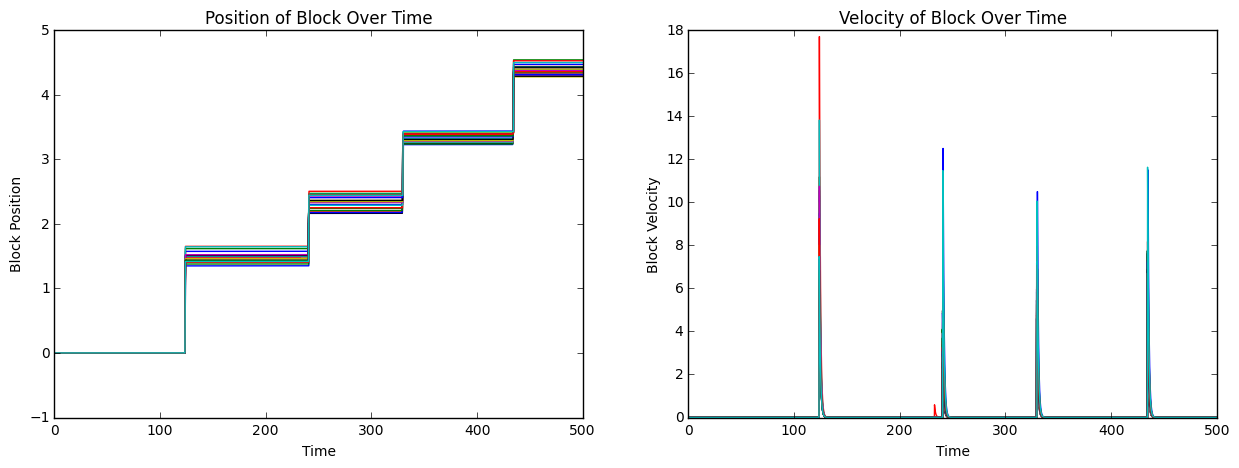

In [55]:
earthquakePlot = np.copy(earthquake)

# Normalizes block positions relative to their equilibrium positions
for n in range(1, blockNum + 1):
    for m in range(0, timeSteps + 1):
        earthquakePlot[m,n] += -n + 1
    
plt.figure(figsize = (15,5))

# Plots all of the block positions on the same plot
plt.subplot(121)
for i in range (1, blockNum + 1):
    plt.plot(earthquakePlot[:,0], earthquakePlot[:, i])
plt.xlabel("Time")
plt.ylabel("Block Position")
plt.title("Position of Block Over Time")

# Plots all of the block velocities on the same plot
plt.subplot(122)
for i in range (0, blockNum):
    plt.plot(earthquakePlot[:,0], earthquakePlot[:, blockNum + i + 1])
plt.xlabel("Time")
plt.ylabel("Block Velocity")
plt.title("Velocity of Block Over Time")

These plots depict the change in position and velocity over a time span of 500 time units of the series of blocks described above. In this example, there are 25 blocks with random spacing within a variation of 0.001 distance units. They are connected by springs with a kc value of 250. Each block's motion is plotted individually with its own color, and its position shown is relative to its equilibrium position.  

The left plot depicts the position of the blocks over time. This shows that the blocks roughly move in sync with each other, but not perfectly. Each time the position increases sharply, an earthquake has happened, and the distance the blocks move is correlated to the magnitude of the event. Because the positions of the blocks was varied slightly, the time at which each event happens, and its magnitude also varies.  

The right plot depicts the velocity of the blocks over time. This matches the derivative of the position plot, and shows that the blocks roughly accelerate and decelerate at the same time, but not precisely, and this slight variation is consistent with what we would expect from a natural system.

In [39]:
earthquakeMoments = countQuakes(earthquakePlot, blockNum, 15)
earthquakeMagnitudes = list(map(np.log,earthquakeMoments))

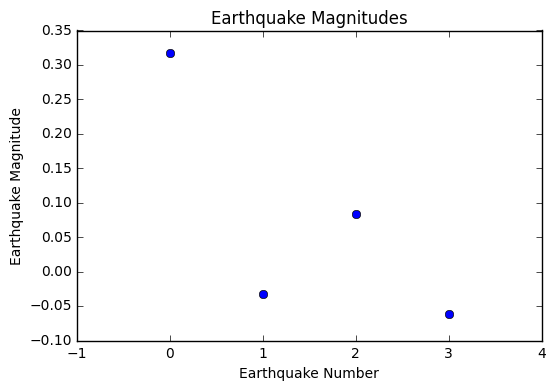

In [41]:
plt.plot(earthquakeMagnitudes, "b o")
plt.title("Earthquake Magnitudes")
plt.xlabel("Earthquake Number")
plt.ylabel("Earthquake Magnitude")
plt.xlim(-1,4)
plt.show()

This is an example of a scatter plot that represents the magnitude of each earthquake that occurred during the above timeframe, in the order that they occurred. Each magnitude was calculated by taking the logarithm of the distance a certain block moved. In this case, I used a single block located towards the center to give an approximation of the magnitude of the overall earthquake.

## Example of Larger Earthquake Model

In [6]:
blockPositions = [] # Array to contain random block positions
testBlockPositions = [] #Test array with set block positions
averageSpacing = 1 # Average spacing between blocks
timeInterval = (0,10000)
kp = 40 # Leaf spring constant
kc = 250 # Spring constant between blocks
mass = 1 # Mass of blocks
F0 = 50 # Static friction force
v0 = 0.01 # Velocity of the top plate
vBlock = 0 # Initial velocity of blocks
vf = 1.0 # Friction coefficient
blockNum = 100 # Number of blocks
timeSteps = 500000
variation = 0.001 # Variation in distance between blocks

# Calculates inital block positions
for n in range(0, blockNum + 1):
    blockPositions.append(n * averageSpacing + (random.random() - 0.5) * 2 * variation)
    testBlockPositions.append(n)

earthquakeBig = eulerCoupled (blockMotion, 2, blockPositions, vBlock, blockNum, timeInterval, timeSteps,\
                            kp, kc, mass, F0, v0, vf)

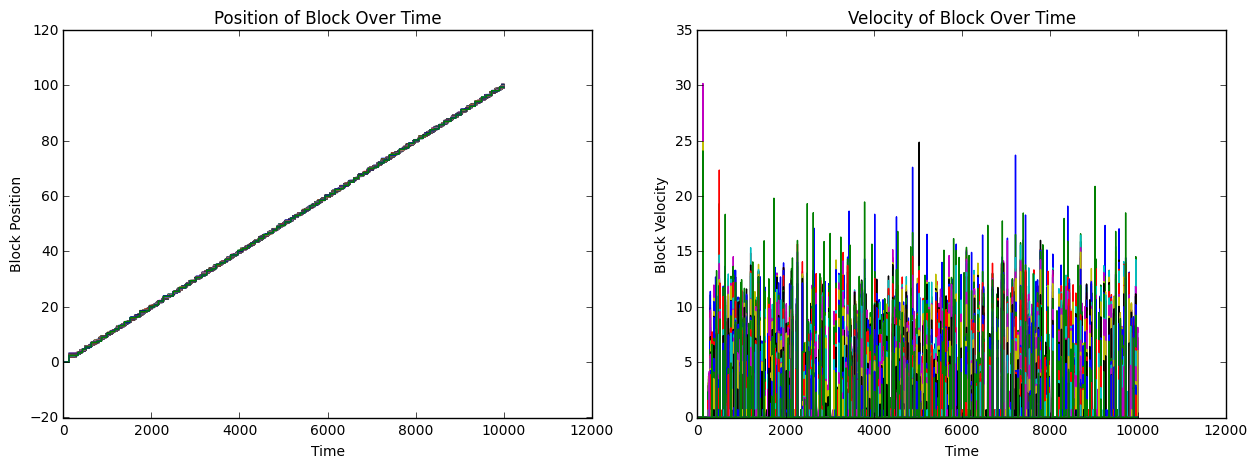

In [7]:
earthquakePlot = np.copy(earthquakeBig)

# Normalizes block positions relative to their equilibrium positions
for n in range(1, blockNum + 1):
    for m in range(0, timeSteps + 1):
        earthquakePlot[m,n] += -n + 1
    
plt.figure(figsize = (15,5))

# Plots all of the block positions on the same plot
plt.subplot(121)
for i in range (1, blockNum + 1):
    plt.plot(earthquakePlot[:,0], earthquakePlot[:, i])
plt.xlabel("Time")
plt.ylabel("Block Position")
plt.title("Position of Block Over Time")

# Plots all of the block velocities on the same plot
plt.subplot(122)
for i in range (0, blockNum):
    plt.plot(earthquakePlot[:,0], earthquakePlot[:, blockNum + i + 1])
plt.xlabel("Time")
plt.ylabel("Block Velocity")
plt.title("Velocity of Block Over Time")

This plot is the same as the one above, except the time interval has been expanded to 10000, and there are 100 block represented instead of 25.

It is difficult to see the exact shape of the position and velocity curves, but, like before, the blocks are roughly in sync with each other, but not exactly. This gives us a better estimate of the average magnitudes that occur, because we have more sample points.

In [8]:
earthquakeMoments = countQuakes(earthquakePlot, blockNum, 50)
earthquakeMagnitudes = list(map(np.log,earthquakeMoments))

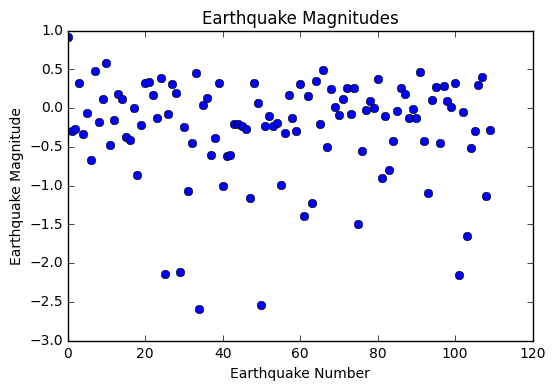

In [10]:
plt.plot(earthquakeMagnitudes, "b o")
plt.title("Earthquake Magnitudes")
plt.xlabel("Earthquake Number")
plt.ylabel("Earthquake Magnitude")
plt.show()

This is a plot of the magnitude of each earthquake that occurs above, in the order that they occur. It provides a clearer image of what is happening in the above plots. The magnitude of each earthquake was calculated by taking the logarithm of the distance the plates shifted relative to each other. From this plot, we can see that the earthquakes tend to have a magnitude around zero.

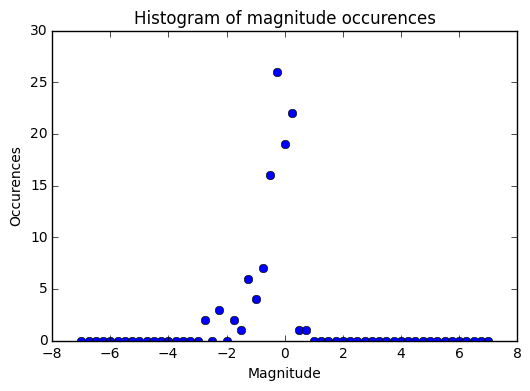

In [56]:
bigMagnitudes, bigOccurences = countMagnitudes (earthquakeMagnitudes)
plt.plot(bigMagnitudes, bigOccurences, "b o")
plt.title("Histogram of magnitude occurences")
plt.xlabel("Magnitude")
plt.ylabel("Occurences")

The above plot is a histogram representing the number of earthquakes that occur within certain magnitude ranges in the given timeframe. From this, we can see that the majority of earthquakes occur around a value of zero.

## Analysis

The first model shows the position and velocity of a system with 25 blocks over a short amount of time (t = 0 to 500). The position shown on the position vs time plot is the relative position of each block to its equilibrium position. The blocks start out approximately one distance unit away from each other, but with a maximum variation of 0.001 distance units. The purpose of this model was to get an idea of the way the blocks move together of a short period of time. From the plots of position and velocity over time, we can see that the blocks roughly move at the same time, and for the same distance, but there is some variation. This is what we expect, because the blocks are connected by strings with a high kc value (250), but the forces on them are slightly different on account of their various positions. In addition, the average distance the blocks move varies from earthquake to earthquake, and so the magnitude of each earthquake is different. This is consistent with what we see in nature.  

After this initial model, I repeated the calculation, but at a much larger time frame (t = 0 to 10000) and with 100 blocks instead of 25. The purpose of this was to get an idea of the average magnitude of the earthquakes, and how often larger earthquakes occur. Beneath my position and velocity plots, I included a scatter plot of depicting the magnitudes of all the earthquakes, and a histogram depicting how often earthquakes within specific ranges of magnitudes occur. I calculated the magnitude by taking the logarithm of the distance one sample block travelled. So far, my histogram is inconclusive, because I have not been able to collect data over a large enough time frame.

## Sources:

[1] Giordano N. 1997. Computational Physics. Upper Sadie River, NJ: Pretence-Hall inc. p. 315-328

[2] Sammis C, Smith S. 1999. Seismic Cycles and the Evolution of Stress Correlation in Cellular
Automaton Models of Finite Fault Networks. Pure and Applied Geophysics. 155(1)

In [22]:
if __name__ == "__main__":
    import doctest
    doctest.testmod()